In [1]:
import numpy as np
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import ast
import json

In [2]:
microstate = "PPP"
input_root = Path("../data/microstates") / microstate
results_root = Path("../results") / microstate

# Buckets and constraint targets (plus label strings)
with (input_root / "symmetry-buckets" / "r8.dat").open() as f:
    buckets = ast.literal_eval(f.read())
bucket_targets = {}
bucket_labels = {}
with (Path("../configs") / microstate / "charge-contraints" / "bucket_constraints.yaml").open() as f:
    for entry in yaml.safe_load(f)["bucket_constraints"]:
        idx = entry["bucket"]
        bucket_targets[idx] = entry["value"]
        bucket_labels[idx] = ",".join(entry.get("labels", []))


In [3]:
def bucket_deltas(charges):
    deltas = {}
    for idx, target in bucket_targets.items():
        atoms = buckets[idx]
        # average across atoms per configuration
        bucket_means = charges[atoms].mean(axis=0)
        deltas[idx] = bucket_means - target
    return deltas

In [4]:
root = results_root
# Two-step RESP (both stages in the NPZ)
twostep = np.load(root / "twostepRESP_basic" / "charges.npz", allow_pickle=True)
ts_step1 = bucket_deltas(twostep["step1"])
ts_step2 = bucket_deltas(twostep["step2"])

# Multiconf RESP (NPY files for step1 + final)
mc_step1 = bucket_deltas(np.load(root / "multiconfRESP" / "charges_step1.npy"))
mc_final = bucket_deltas(np.load(root / "multiconfRESP" / "charges_final.npy"))

def max_abs(diff_dict):
    return [np.max(np.abs(diff_dict[idx])) for idx in indices]


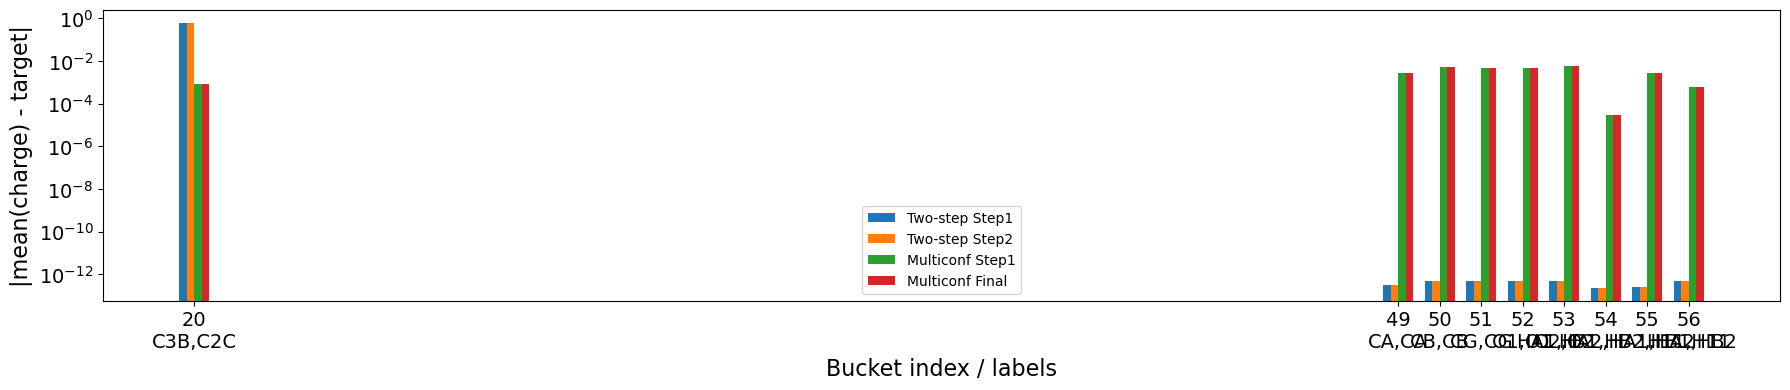

In [5]:
indices = sorted(bucket_targets.keys())
xtick_labels = [f"{idx}\n{bucket_labels.get(idx, '')}" for idx in indices]
width = 0.18

plt.figure(figsize=(18, 4))
plt.bar([i - 1.5*width for i in indices], max_abs(ts_step1), width=width, label="Two-step Step1")
plt.bar([i - 0.5*width for i in indices], max_abs(ts_step2), width=width, label="Two-step Step2")
plt.bar([i + 0.5*width for i in indices], max_abs(mc_step1),  width=width, label="Multiconf Step1")
plt.bar([i + 1.5*width for i in indices], max_abs(mc_final), width=width, label="Multiconf Final")
plt.yscale("log")
plt.xticks(indices, xtick_labels, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Bucket index / labels", fontsize=16)
plt.ylabel("|mean(charge) - target|", fontsize=16)
plt.legend(fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

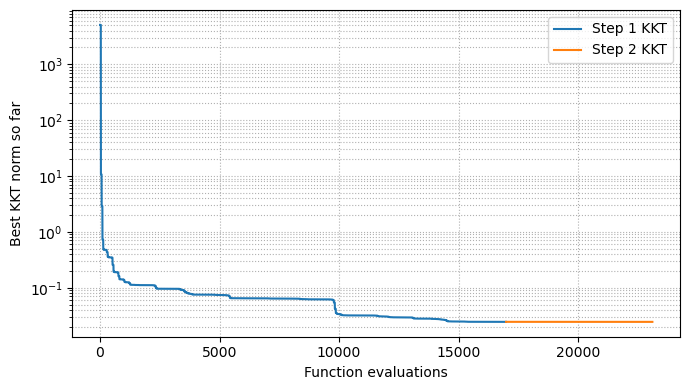

In [6]:
def running_min(values):
    return np.minimum.accumulate(values)

root = Path("../results/PPP/multiconfRESP")
fig, ax = plt.subplots(figsize=(7, 4))

# Load step 1 first so we know its final eval
with (root / "resp_step1_log.json").open() as f:
    step1 = json.load(f)
step1_evals = [d["eval"] for d in step1]
step1_kkt = [d["kkt_norm"] for d in step1]
ax.semilogy(step1_evals, running_min(step1_kkt), label="Step 1 KKT")

step1_last_eval = step1_evals[-1]

# Step 2: shift the eval axis by the last step1 eval
with (root / "resp_step2_log.json").open() as f:
    step2 = json.load(f)
step2_evals = [step1_last_eval + d["eval"] for d in step2]
step2_kkt = [d["kkt_norm"] for d in step2]
ax.semilogy(step2_evals, running_min(step2_kkt), label="Step 2 KKT")

ax.set_xlabel("Function evaluations")
ax.set_ylabel("Best KKT norm so far")
ax.legend()
ax.grid(True, which="both", ls=":")
fig.tight_layout()
plt.show()


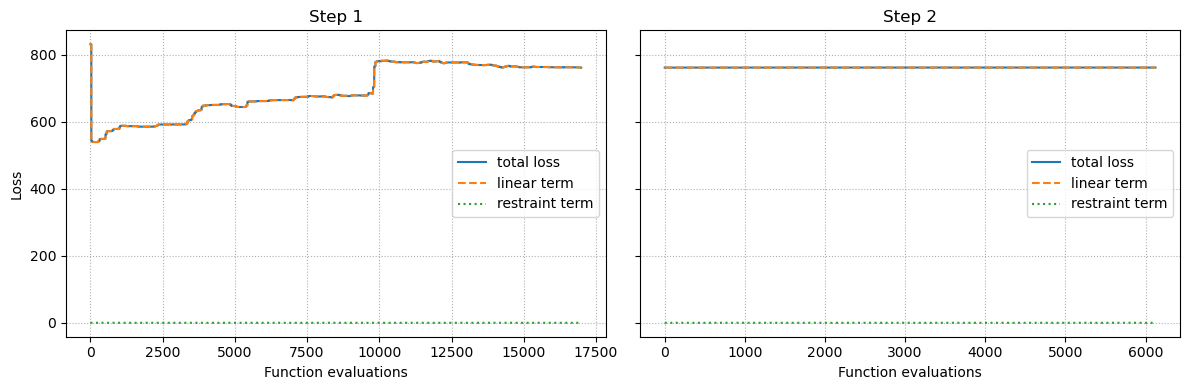

In [7]:
root = Path("../results/PPP/multiconfRESP")

def load_loss(name):
    with (root / name).open() as f:
        data = json.load(f)
    evals = [entry["eval"] for entry in data]
    loss = [entry["loss"] for entry in data]
    loss_linear = [entry["loss_linear"] for entry in data]
    loss_restraint = [entry["loss_restraint"] for entry in data]
    return evals, loss, loss_linear, loss_restraint

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for ax, fname, title in zip(
    axes,
    ["resp_step1_log.json", "resp_step2_log.json"],
    ["Step 1", "Step 2"],
):
    evals, loss, loss_lin, loss_rest = load_loss(fname)
    ax.plot(evals, loss, label="total loss")
    ax.plot(evals, loss_lin, "--", label="linear term")
    ax.plot(evals, loss_rest, ":",
            label="restraint term")
    ax.set_title(title)
    ax.set_xlabel("Function evaluations")
    ax.set_yscale("linear") # also make it log
    ax.grid(True, which="both", ls=":")
    if ax is axes[0]:
        ax.set_ylabel("Loss")
    ax.legend()

fig.tight_layout()
plt.show()


In [8]:
root = Path("../results/PPP/multiconfRESP")
step1_total = np.load(root / "charges_step1.npy").sum()
step2_total = np.load(root / "charges_final.npy").sum()

print(f"Step 1 total charge: {step1_total:+.6f}")
print(f"Step 2 total charge: {step2_total:+.6f}")


Step 1 total charge: +0.999254
Step 2 total charge: +1.000000
